# Assignment 4: LSTM from Scratch using MxNet
***
Submitted By: Suyash Damle

Roll : 15CS10057

***

### NOTE:
- The code requires **pre-trained FastText embeddings**. These are available here: https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip  & it should be unzipped
- The file location of the train,test data & embeddings are to be specified as a global variables in the "Global Variables" section
- **As the parameter files were too large, I have uploaded them on google drive. They are available on these links:**
    - for one-hot encoding model: https://drive.google.com/file/d/182DnuEdSaso1Q03-ZzXhOpg09rhitTiY/view?usp=sharing
    - for embeddings model: https://drive.google.com/file/d/1NkTpkSyFm0bgKHEKuJDpxH0FZaMfdohi/view?usp=sharing

In [1]:
import mxnet as mx
from mxnet import nd
from mxnet import autograd
import numpy as np
import re
import io
import pickle
from zipfile import ZipFile
import matplotlib.pyplot as plt
%matplotlib inline

#### Global Variables

In [2]:
train_file = "data/train.txt"
test_file = "data/test.txt"
embeddings_file = "data/wiki-news-300d-1M.vec"
short_embeddings_file = "data/short_embeddings_file.pkl"

### Global Parameters
embedding_matrix = None
embedding_size = 300
vocab_dict = None
ctx = mx.cpu()

#### Preprocessing

In [3]:
# function to get FastText word embeddings for our specific vocab
def load_vectors(fname, vocab_dict):
    '''
    Since our vocab is expected to much smaller than the fasttext vocab, we only...
    ... retain the embeddings required for our purpose in the main memory.
    Special token </s>(the start symbol) is assigned all-zero embeddings.
    
    Params:
        fname : the name of the zip of the file
        vocab : the vocab dict of our dataset: <token : idx>
    Returns:
        np array: row at the idx of token (from dict) contains the embedding
    '''
    
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = np.zeros((len(vocab_dict),embedding_size))
    for line in fin:
        tokens = line.rstrip().split(' ')
        if (tokens[0] in vocab_dict.keys()) or tokens[0]=='</s>':
            if tokens[0] == '</s>':
                data[vocab_dict['</s>']]=np.zeros(embedding_size)
            elif tokens[0] =='/e':
                data[vocab_dict['/e']]=np.ones(embedding_size)
            else:
                data[vocab_dict[tokens[0]]] = np.array(list(map(float, tokens[1:])))
    pickle.dump(data,open(short_embeddings_file,'wb'))
    return data

In [4]:
def preprocess(sentences):
    sents=[]
    for sent in sentences:
        sent = re.sub(r"^[a-zA-Z]"," ",sent)
        sent=sent.lower().split()
#         sent.insert(0,'</s>')
#         sent.append('</e>')
        sents.append(sent)
        
    return sents    
        
    
def build_vocab(sentences):
    """
    Builds a vocabulary mapping from token to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    tokens=[]
    # Mapping from index to word
    for sent in sentences:
        tokens.extend(sent)
        
    vocabulary_inv=list(set(tokens))
    
    # Mapping from word to index
    vocabulary = {vocabulary_inv[i]: i for i in range(len(vocabulary_inv))}
    
    return vocabulary, vocabulary_inv

def create_sent_representation(sent,type='one-hot'):
    '''
    Returns an embedding matrix for the string
    Params:
        sent: the string to be converted to matrix
        type: 'one-hot' / 'pre-trained'
    Returns:
        list of vectors representing the sentence
    '''
    global embedding_matrix
    #sent_matrix = None
    sent_matrix=[]
    if (type == 'pre-trained') and (embedding_matrix is None):
        embedding_matrix = load_vectors(embeddings_file,vocab_dict)
        #sent_matrix = np.zeros((len(sent), embedding_size))
    #else:
        #sent_matrix = np.zeros((len(sent), len(vocab_dict)))
        
    for idx,word in enumerate(sent):
        if type=='one-hot':
            vect = np.zeros(len(vocab_dict))
            vect[vocab_dict[word]] = 1
            #sent_matrix[idx] = vect
            sent_matrix.append(vect)
        else:
            #sent_matrix[idx] = embedding_matrix[vocab_dict[word]]
            sent_matrix.append(embedding_matrix[vocab_dict[word]])
    return sent_matrix


In [18]:
with open(train_file,'r') as f:
    train_data=f.readlines()
with open(test_file,'r') as f:
    test_data=f.readlines()
l_train = len(train_data)
all_data = train_data+test_data

In [19]:
all_data = preprocess(all_data)
vocab_dict , inv_vocab = build_vocab(all_data)

#### The LSTM model from scratch
***
Following are the formulae:

$$g_t = \text{tanh}(X_t W_{xg} + h_{t-1} W_{hg} + b_g)$$
$$i_t = \sigma(X_t W_{xi} + h_{t-1} W_{hi} + b_i)$$
$$f_t = \sigma(X_t W_{xf} + h_{t-1} W_{hf} + b_f)$$
$$o_t = \sigma(X_t W_{xo} + h_{t-1} W_{ho} + b_o)$$
$$c_t = f_t \odot c_{t-1} + i_t \odot g_t$$
$$h_t = o_t \odot \text{tanh}(c_t)$$

## Using the One-Hot encodings

In [7]:
vocab_size = len(vocab_dict)
num_inputs = vocab_size
num_hidden = 100
num_outputs = vocab_size

#  Weights connecting the inputs to the hidden layer
Wxg = nd.random_normal(shape=(num_inputs,num_hidden), ctx=ctx) * .01
Wxi = nd.random_normal(shape=(num_inputs,num_hidden), ctx=ctx) * .01
Wxf = nd.random_normal(shape=(num_inputs,num_hidden), ctx=ctx) * .01
Wxo = nd.random_normal(shape=(num_inputs,num_hidden), ctx=ctx) * .01

#  Recurrent weights connecting the hidden layer across time steps
Whg = nd.random_normal(shape=(num_hidden,num_hidden), ctx=ctx)* .01
Whi = nd.random_normal(shape=(num_hidden,num_hidden), ctx=ctx)* .01
Whf = nd.random_normal(shape=(num_hidden,num_hidden), ctx=ctx)* .01
Who = nd.random_normal(shape=(num_hidden,num_hidden), ctx=ctx)* .01

#  Bias vector for hidden layer
bg = nd.random_normal(shape=num_hidden, ctx=ctx) * .01
bi = nd.random_normal(shape=num_hidden, ctx=ctx) * .01
bf = nd.random_normal(shape=num_hidden, ctx=ctx) * .01
bo = nd.random_normal(shape=num_hidden, ctx=ctx) * .01

# Weights to the output nodes
Why = nd.random_normal(shape=(num_hidden,num_outputs), ctx=ctx) * .01
by = nd.random_normal(shape=num_outputs, ctx=ctx) * .01


# The gradients attached
params = [Wxg, Wxi, Wxf, Wxo, Whg, Whi, Whf, Who, bg, bi, bf, bo, Why, by]
for param in params:
    param.attach_grad()

In [8]:
def softmax(y_linear):
    lin = (y_linear-nd.max(y_linear))
    exp = nd.exp(lin)
    partition = nd.sum(exp, axis=0, exclude=True).reshape((-1,1))
    return exp / partition

def cross_entropy(yhat, y):
    return - nd.mean(nd.sum(y * nd.log(yhat), axis=0, exclude=True))

In [9]:
def lstm_rnn(inputs, h, c):
    outputs = []
    for X in inputs:
        #X = nd.array(X, ctx=ctx)
        g = nd.tanh(nd.dot(X, Wxg) + nd.dot(h, Whg) + bg)
        i = nd.sigmoid(nd.dot(X, Wxi) + nd.dot(h, Whi) + bi)
        f = nd.sigmoid(nd.dot(X, Wxf) + nd.dot(h, Whf) + bf)
        o = nd.sigmoid(nd.dot(X, Wxo) + nd.dot(h, Who) + bo)
        c = f * c + i * g
        h = o * nd.tanh(c)
        yhat_linear = nd.dot(h, Why) + by
        yhat = softmax(yhat_linear)
        outputs.append(yhat)
    return (outputs, h, c)

def average_ce_loss(outputs, labels):
    #labels = nd.array(labels, ctx=ctx)
    assert(len(outputs) == len(labels))
    total_loss = 0.
    for (output, label) in zip(outputs,labels):
        total_loss = total_loss + cross_entropy(output, label)
    return total_loss / len(outputs)

def SGD(params, lr):
    for param in params:
        # with gradient clipping
        param[:] = param - lr * param.grad

#### Other specifics for the model

In [20]:
all_vects = []
for sent in all_data:
    all_vects.append(create_sent_representation(sent))
train_data_org = all_vects[:l_train]
test_data_org = all_vects[l_train:]

In [21]:
train_data_cont=[]
for sent in train_data_org:
    train_data_cont.extend(sent)

batch_size = 128
seq_length = 1
# -1 here so we have enough characters for labels later
num_samples = (len(train_data_cont) - 1) // seq_length
dataset = train_data_cont[:seq_length*num_samples]
dataset = np.array(dataset).reshape((num_samples, seq_length, vocab_size))
num_batches = len(dataset) // batch_size
train_data = dataset[:num_batches*batch_size].reshape((num_batches, batch_size, seq_length, vocab_size))
# swap batch_size and seq_length axis to make later access easier
train_data = np.swapaxes(train_data, 1, 2)
labels = (train_data_cont[1:seq_length*num_samples+1])[:num_batches*batch_size]
train_label = np.array(labels).reshape((num_batches, batch_size, seq_length, vocab_size))
train_label = np.swapaxes(train_label, 1, 2)

In [12]:
print(len(train_data_cont))
print(dataset.shape)
print(train_data.shape)

33788
(33787, 1, 7161)
(263, 1, 128, 7161)


In [62]:
def test_fn(test_data, type=1,encoding='one-hot'):
    total_pred=0.0
    correct_pred=0.0
    for sent in test_data:
        h = nd.zeros(shape=(1, num_hidden), ctx=ctx)
        c = nd.zeros(shape=(1, num_hidden), ctx=ctx)
        if type==1:
            total_pred +=1
            input_sequence = nd.array(sent[:-1], ctx=ctx)
            outputs, h, c = lstm_rnn(input_sequence, h, c)
            if np.argmax(sent[-1])==np.argmax(outputs[-1].asnumpy()):
                correct_pred+=1
        else:
            input_sequence = nd.array(sent[:int(len(sent)/2)],ctx=ctx)
            yhat,h,c = lstm_rnn(input_sequence, h, c)
            # run on first half of sentence:
            for word in sent[int(len(sent)/2):]:
                total_pred+=1
                # feed previous output as input this time
                X=yhat[-1]
                if encoding=='pre-trained':
                    #print(np.argmax(yhat[-1].asnumpy()))
                    X=nd.array(embedding_matrix[np.argmax(yhat[-1].asnumpy())],ctx=ctx)
                g = nd.tanh(nd.dot(X, Wxg) + nd.dot(h, Whg) + bg)
                i = nd.sigmoid(nd.dot(X, Wxi) + nd.dot(h, Whi) + bi)
                f = nd.sigmoid(nd.dot(X, Wxf) + nd.dot(h, Whf) + bf)
                o = nd.sigmoid(nd.dot(X, Wxo) + nd.dot(h, Who) + bo)
                c = f * c + i * g
                h = o * nd.tanh(c)
                yhat_linear = nd.dot(h, Why) + by
                yhat = softmax(yhat_linear)
                if np.argmax(yhat[-1].asnumpy)==np.argmax(word):
                    correct_pred+=1
            
    acc = correct_pred/total_pred
    return acc

In [22]:
epochs = 30
learning_rate = 4

train_data = nd.array(train_data, ctx=ctx)
train_label = nd.array(train_label, ctx=ctx)

h = nd.zeros(shape=(batch_size, num_hidden), ctx=ctx)
c = nd.zeros(shape=(batch_size, num_hidden), ctx=ctx)

# state = nd.zeros(shape=(batch_size, num_hidden), ctx=ctx)
epoch_data=[]
error_data=[]
for e in range(epochs):
    # Attenuate the learning rate by a factor of 2 every 5 epochs
    if ((e+1) % 5 == 0):
        learning_rate = learning_rate / 2.0

    for i in range(num_batches):
        data_one_hot = train_data[i]
        label_one_hot = train_label[i]
        with autograd.record():
            outputs, h, c = lstm_rnn(data_one_hot, h, c)
            loss = average_ce_loss(outputs, label_one_hot)
            loss.backward()
        SGD(params, learning_rate)
        op_loss = nd.mean(loss).asscalar()
    epoch_data.append(e+1)
    error_data.append(op_loss)
    if e%5==0:
        print("Epoch %s. Loss: %s" % (e, op_loss))

Epoch 0. Loss: 6.69921
Epoch 5. Loss: 5.89201
Epoch 10. Loss: 5.52554
Epoch 15. Loss: 5.38315
Epoch 20. Loss: 5.30624
Epoch 25. Loss: 5.27942


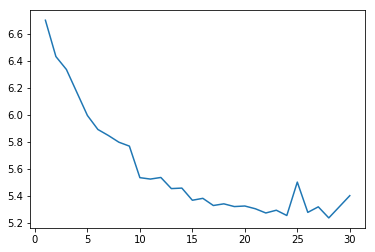

In [24]:
plt.plot(epoch_data,error_data)
plt.show()

In [25]:
nd.save("data/saved_params",params)

### Sample Predictions

In [38]:
sent = "this is the" #....
sent = create_sent_representation(sent.split())
h = nd.zeros(shape=(1, num_hidden), ctx=ctx)
c = nd.zeros(shape=(1, num_hidden), ctx=ctx)
outputs,_,_ = lstm_rnn(nd.array(sent,  ctx=ctx),h,c)
print(inv_vocab[np.argmax(outputs[-1].asnumpy())])

best


In [39]:
print ("accuracy for predicting last word is:" ,test_fn(test_data_org))
print ("accuracy for predicting half the sentence is:" ,test_fn(test_data_org,type=2))

accuracy for predicting last word is: 0.02046783625730994
accuracy for predicting half the sentence is: 0.0


## Using FastText Word Embeddings

In [40]:
vocab_size = len(vocab_dict)
num_inputs = embedding_size
num_hidden = 100
num_outputs = vocab_size

#  Weights connecting the inputs to the hidden layer
Wxg = nd.random_normal(shape=(num_inputs,num_hidden), ctx=ctx) * .01
Wxi = nd.random_normal(shape=(num_inputs,num_hidden), ctx=ctx) * .01
Wxf = nd.random_normal(shape=(num_inputs,num_hidden), ctx=ctx) * .01
Wxo = nd.random_normal(shape=(num_inputs,num_hidden), ctx=ctx) * .01

#  Recurrent weights connecting the hidden layer across time steps
Whg = nd.random_normal(shape=(num_hidden,num_hidden), ctx=ctx)* .01
Whi = nd.random_normal(shape=(num_hidden,num_hidden), ctx=ctx)* .01
Whf = nd.random_normal(shape=(num_hidden,num_hidden), ctx=ctx)* .01
Who = nd.random_normal(shape=(num_hidden,num_hidden), ctx=ctx)* .01

#  Bias vector for hidden layer
bg = nd.random_normal(shape=num_hidden, ctx=ctx) * .01
bi = nd.random_normal(shape=num_hidden, ctx=ctx) * .01
bf = nd.random_normal(shape=num_hidden, ctx=ctx) * .01
bo = nd.random_normal(shape=num_hidden, ctx=ctx) * .01

# Weights to the output nodes
Why = nd.random_normal(shape=(num_hidden,num_outputs), ctx=ctx) * .01
by = nd.random_normal(shape=num_outputs, ctx=ctx) * .01


# The gradients attached
params = [Wxg, Wxi, Wxf, Wxo, Whg, Whi, Whf, Who, bg, bi, bf, bo, Why, by]
for param in params:
    param.attach_grad()

In [41]:
all_vects = []
for sent in all_data:
    all_vects.append(create_sent_representation(sent,type="pre-trained"))
train_data_org = all_vects[:l_train]
test_data_org = all_vects[l_train:]

In [42]:
train_data_cont=[]
for sent in train_data_org:
    train_data_cont.extend(sent)
    
# Splitting into batches

batch_size = 128
seq_length = 1
# -1 here so we have enough characters for labels later
num_samples = (len(train_data_cont) - 1) // seq_length
dataset = train_data_cont[:seq_length*num_samples]
dataset = np.array(dataset).reshape((num_samples, seq_length, embedding_size))
num_batches = len(dataset) // batch_size
train_data = dataset[:num_batches*batch_size].reshape((num_batches, batch_size, seq_length, embedding_size))
# swap batch_size and seq_length axis to make later access easier
train_data = np.swapaxes(train_data, 1, 2)
# labels = (train_data_cont[1:seq_length*num_samples+1])[:num_batches*batch_size]
# train_label = np.array(labels).reshape((num_batches, batch_size, seq_length, embedding_size))
# train_label = np.swapaxes(train_label, 1, 2)

In [44]:
epochs = 30
learning_rate = 4

train_data = nd.array(train_data, ctx=ctx)
train_label = nd.array(train_label, ctx=ctx)

h = nd.zeros(shape=(batch_size, num_hidden), ctx=ctx)
c = nd.zeros(shape=(batch_size, num_hidden), ctx=ctx)
epoch_data=[]
error_data=[]
# state = nd.zeros(shape=(batch_size, num_hidden), ctx=ctx)
for e in range(epochs):
    # Attenuate the learning rate by a factor of 2 every 2 epochs
    if ((e+1) % 5 == 0):
        learning_rate = learning_rate / 2.0
    
    for i in range(num_batches):
        data_one_hot = train_data[i]
        label_one_hot = train_label[i]
        with autograd.record():
            outputs, h, c = lstm_rnn(data_one_hot, h, c)
            loss = average_ce_loss(outputs, label_one_hot)
            loss.backward()
        SGD(params, learning_rate)
        op_loss = nd.mean(loss).asscalar()
    epoch_data.append(e+1)
    error_data.append(op_loss)
    if e%5==0:
        print("Epoch %s. Loss: %s" % (e, op_loss))

Epoch 0. Loss: 6.48249
Epoch 5. Loss: 5.76998
Epoch 10. Loss: 5.25046
Epoch 15. Loss: 4.97071
Epoch 20. Loss: 4.8946
Epoch 25. Loss: 4.87144


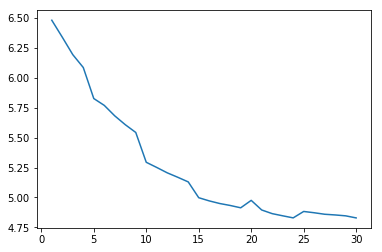

In [45]:
plt.plot(epoch_data,error_data)
plt.show()

In [46]:
nd.save("data/saved_params_2",params)

In [64]:
print ("accuracy for predicting last word is:" ,test_fn(test_data_org,encoding='pre-trained'))
print ("accuracy for predicting half the sentence is:" ,test_fn(test_data_org,type=2,encoding='pre-trained'))

accuracy for predicting last word is: 0.0
accuracy for predicting half the sentence is: 0.030256251929607902
